In [1]:
import uproot as up
import awkward as ak
import pandas as pd
from scipy.optimize import curve_fit

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm, trange
from pathlib import Path

import mplhep as hep
hep.style.use('ROOT')

In [2]:
class Event:
    def __init__(self, 
                 timestamp, time_since_last_trigger, 
                 hit_id, hit_charge, hit_time, 
                 xfit, yfit, zfit,
                 waveforms):

        # Event timing data 
        self.timestamp = timestamp 
        self.time_since_last_trigger = time_since_last_trigger
        self.time_since_last_prompt_trigger = None

        # Event trigger data
        self.trigger_type = 2
        self.trigger_group = None # For finding the prompt that caused it

        ##############################################################################
        ### SOMETIMES THE CHARGE IS JUST WRONG!!! SHOULD PROCESS WAVEFORMS MYSELF! ###
        ##############################################################################

        # Channel data 
        self.waveforms = waveforms
        self.hit_id = hit_id
        self.hit_charge = hit_charge
        self.hit_time = hit_time
        self.good_channel_mask = np.zeros(len(hit_id)) # Fixes the bad processor most of the time

        # Quadfitter data
        self.xfit = xfit
        self.yfit = yfit
        self.zfit = zfit
 
    def make_good_channel_mask(self,charge_threshold=0.8,ratio_threshold=2):
        # Get the channel that was hit
        for i, id in enumerate(self.hit_id):
            # Check the charge
            if self.hit_charge[i]>=charge_threshold:
                # Check ratio that is roughly equivalent to the signal to noise ratio of the waveform
                wf = self.waveforms[id]
                ratio = (np.median(wf)-np.min(wf))/(np.max(wf)-np.median(wf)) 
                if ratio>=ratio_threshold:
                    self.good_channel_mask[i]=1
        
class Run:
    def __init__(self,number):
        # Run data
        self.number = number 
        self.files = []

        # Eent meta data
        self.pmt_type = None
        self.pmt_id = None
        self.pmt_ch = None
        self.pmt_is_online = None # channel bitmask 
        self.pmt_cable_offset = None

        # Event output and waveform data 
        self.events = []
        self.good_event_mask = [] # event bitmask  
 
    def get_files(self, path):
        path = Path(path)
        files = list(path.glob("*/*.root"))
        for f in files:
            if f"run{self.number}" in f.as_posix():
                self.files.append(f)
        self.files = sorted(self.files, key=lambda x: int(x.stem.split('_')[2].split('.')[0]))
        print(f"Found {len(self.files)} files for run {self.number}")
        #self.files=self.files[:1]

    # Just need to open the first file
    def load_meta_data(self):
        f=up.open(self.files[0])

        print(f"Meta Keys: {f['meta'].keys()}")
        print(f"Output Keys: {f['output'].keys()}")
        print(f"Waveform Keys: {f['waveforms'].keys()}")

        self.pmt_type = f['meta']['pmtType'].array(library='np')[0]
        self.pmt_id = f['meta']['pmtId'].array(library='np')[0]
        self.pmt_ch = f['meta']['pmtChannel'].array(library='np')[0]
        self.pmt_is_online = f['meta']['pmtIsOnline'].array(library='np')[0]
        self.pmt_cable_offset = f['meta']['pmtCableOffset'].array(library='np')[0]

    # Open all the files
    def load_event_data(self):
        for file in tqdm(self.files, desc=f"Parsing event data for {len(self.files)} files for run {self.number}", colour='green'):
            f=up.open(file)

            # Trigger timing 
            timestamp = f['output']['timestamp'].array(library='ak')
            time_since_last_trigger = f['output']['timeSinceLastTrigger_us'].array(library='ak')

            # Hit data
            hit_id = f['output']['digitPMTID'].array(library='ak')
            hit_charge = f['output']['digitCharge'].array(library='ak')
            hit_time = f['output']['digitTime'].array(library='ak')

            # Event vertex reconstruction
            xfit = f['output']['x_quadfitter'].array(library='ak')
            yfit = f['output']['y_quadfitter'].array(library='ak')
            zfit = f['output']['z_quadfitter'].array(library='ak')

            # Channel waveforms 
            waveforms = f['waveforms']['waveform'].array(library='np')
            waveform_id = f['waveforms']['waveform_pmtid'].array(library='np')

            # Remove all waveforms with negative pmt ids 
            # They are the channel 15s used to trigger the CAENs
            waveforms = waveforms[waveform_id>=0]
            waveforms = waveforms.reshape((len(hit_id),len(self.pmt_id))) 
             
            # Create event class instances
            for i in range(len(hit_id)):
                event = Event(
                    timestamp[i],
                    time_since_last_trigger[i],
                    hit_id[i],
                    hit_charge[i],
                    hit_time[i],
                    xfit[i],
                    yfit[i],
                    zfit[i],
                    waveforms[i],
                )
                event.make_good_channel_mask() 
                self.events.append(event)

    # Event selection
    def reset_downstream(self):
        for event in self.events:
            event.trigger_type = 2 
            event.time_since_last_prompt_trigger = None
            
    def set_trigger_types_with_nhit(self,prompt_nhit_range, follower_nhit_range,use_good_channel_mask=False):
        for event in self.events:
            nhit = len(event.hit_id)
            if use_good_channel_mask:
                nhit = ak.sum(event.good_channel_mask)
            if prompt_nhit_range[0] <= nhit < prompt_nhit_range[1]:
                event.trigger_type = 0 
            elif follower_nhit_range[0] <= nhit < follower_nhit_range[1]:
                event.trigger_type = 1 
    
    def set_time_since_last_promp_trigger(self):
        last_prompt_time = 0
        for event in self.events:
            event.time_since_last_prompt_trigger = (event.timestamp - last_prompt_time) / 1e3
            if event.trigger_type==0:
                last_prompt_time = event.timestamp



In [3]:
# path = '/nfs/disk1/eos/eos-processed-data-nubar/'
path = '/nfs/disk1/users/bharris/eos/new_sim/'

run = Run(1246)
run.get_files(path)
run.load_meta_data()
run.load_event_data()


Found 5 files for run 1246
Meta Keys: ['runId', 'runType', 'runTime', 'dsentries', 'macro', 'pmtType', 'pmtId', 'pmtChannel', 'pmtIsOnline', 'pmtCableOffset', 'pmtChargeScale', 'pmtPulseWidthScale', 'pmtX', 'pmtY', 'pmtZ', 'pmtU', 'pmtV', 'pmtW', 'digitizerWindowSize', 'digitizerSampleRate_GHz', 'digitizerDynamicRange_mV', 'digitizerResolution_mVPerADC', 'calibId', 'calibMode', 'calibIntensity', 'calibWavelength', 'calibName', 'calibTime', 'calibX', 'calibY', 'calibZ', 'calibU', 'calibV', 'calibW', 'geo_index', 'geo_file', 'experiment', 'source_pos_x', 'source_pos_y', 'source_pos_z', 'source_rot_x', 'source_rot_y', 'source_rot_z']
Output Keys: ['mcpdg', 'mcx', 'mcy', 'mcz', 'mcu', 'mcv', 'mcw', 'mcke', 'mct', 'evid', 'subev', 'nhits', 'triggerTime', 'timestamp', 'trigger_word', 'timeSinceLastTrigger_us', 'mcid', 'mcparticlecount', 'mcpecount', 'mcnhits', 'scintEdep', 'scintEdepQuenched', 'scintPhotons', 'remPhotons', 'cherPhotons', 'hitPMTID', 'hitPMTTime', 'hitPMTCharge', 'digitNhits'

Parsing event data for 5 files for run 1246:  20%|██        | 1/5 [00:17<01:09, 17.29s/it]/tmp/ipykernel_3427600/3738884125.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  ratio = (np.median(wf)-np.min(wf))/(np.max(wf)-np.median(wf))
Parsing event data for 5 files for run 1246: 100%|██████████| 5/5 [01:23<00:00, 16.72s/it]


Got 107.32 s of data
******************************************
Prompt trigger frequency 1320.308 Hz
Follower trigger frequency 47.251 Hz
******************************************
Cleaned Prompt trigger frequency 568.168 Hz
Cleaned Follower trigger frequency 33.237 Hz


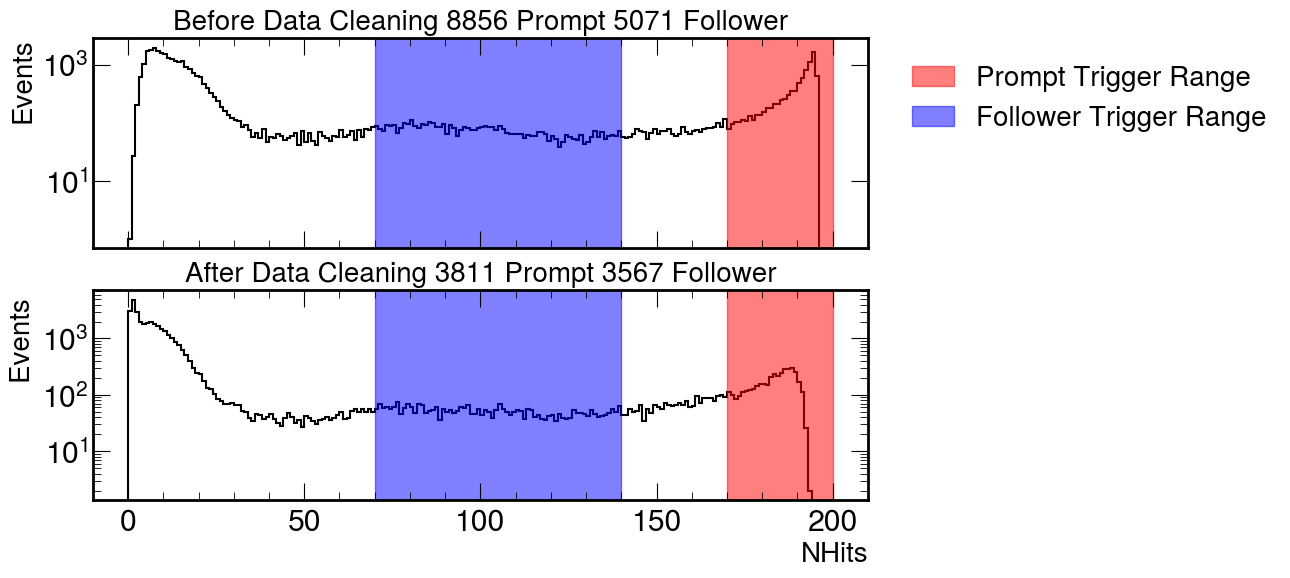

In [90]:
prompt_nhit_range = (170,200)
follower_nhit_range = (70,140)

# Get trigger types and time since last prompt trigger for cleaned and uncleaned data

run.reset_downstream()
run.set_trigger_types_with_nhit(prompt_nhit_range, follower_nhit_range,use_good_channel_mask=False)
run.set_time_since_last_promp_trigger()

trigger_counts = {0: 0, 1: 0, 2: 0}
for event in run.events:
    trigger_counts[event.trigger_type] += 1

run.reset_downstream()
run.set_trigger_types_with_nhit(prompt_nhit_range, follower_nhit_range,use_good_channel_mask=True)
run.set_time_since_last_promp_trigger()

cleaned_trigger_counts = {0: 0, 1: 0, 2: 0}
for event in run.events:
    cleaned_trigger_counts[event.trigger_type] += 1

# Print the dirty and clean trigger rates 

prescale = 16
ts = [event.timestamp for event in run.events]
run_time = (ts[-1]-ts[0])/1e9

print(f"Got {run_time:.2f} s of data")
print("******************************************")
print(f"Prompt trigger frequency {16*trigger_counts[0]/run_time:.3f} Hz")
print(f"Follower trigger frequency {trigger_counts[1]/run_time:.3f} Hz")
print("******************************************")
print(f"Cleaned Prompt trigger frequency {16*cleaned_trigger_counts[0]/run_time:.3f} Hz")
print(f"Cleaned Follower trigger frequency {cleaned_trigger_counts[1]/run_time:.3f} Hz")

# Plot dirty and clean nhits 

nhits = [len(event.hit_id) for event in run.events]
cleaned_nhits = [ak.sum(event.good_channel_mask) for event in run.events]

fig,ax = plt.subplots(2,1,figsize=(10, 6),sharex=True)

hep.histplot(np.histogram(nhits, bins=200, range=(0, 200)), ax=ax[0], color='black')
ax[0].axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Trigger Range')
ax[0].axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Trigger Range')
ax[0].legend(loc='upper right',bbox_to_anchor=(1.55, 1),fontsize=20)
ax[0].set_title(f"Before Data Cleaning {trigger_counts[0]} Prompt {trigger_counts[1]} Follower",fontsize=20)
ax[0].set_ylabel('Events', fontsize=20)
ax[0].set_yscale('log')

hep.histplot(np.histogram(cleaned_nhits, bins=200, range=(0, 200)), ax=ax[1], color='black')
ax[1].axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Trigger Range')
ax[1].axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Trigger Range')
ax[1].set_title(f"After Data Cleaning {cleaned_trigger_counts[0]} Prompt {cleaned_trigger_counts[1]} Follower",fontsize=20)
ax[1].set_xlabel('NHits', fontsize=20) 
ax[1].set_ylabel('Events ',fontsize=20)
ax[1].set_yscale('log')


Text(0.5, 1.0, '$\\Delta$ TS since last prompt trigger')

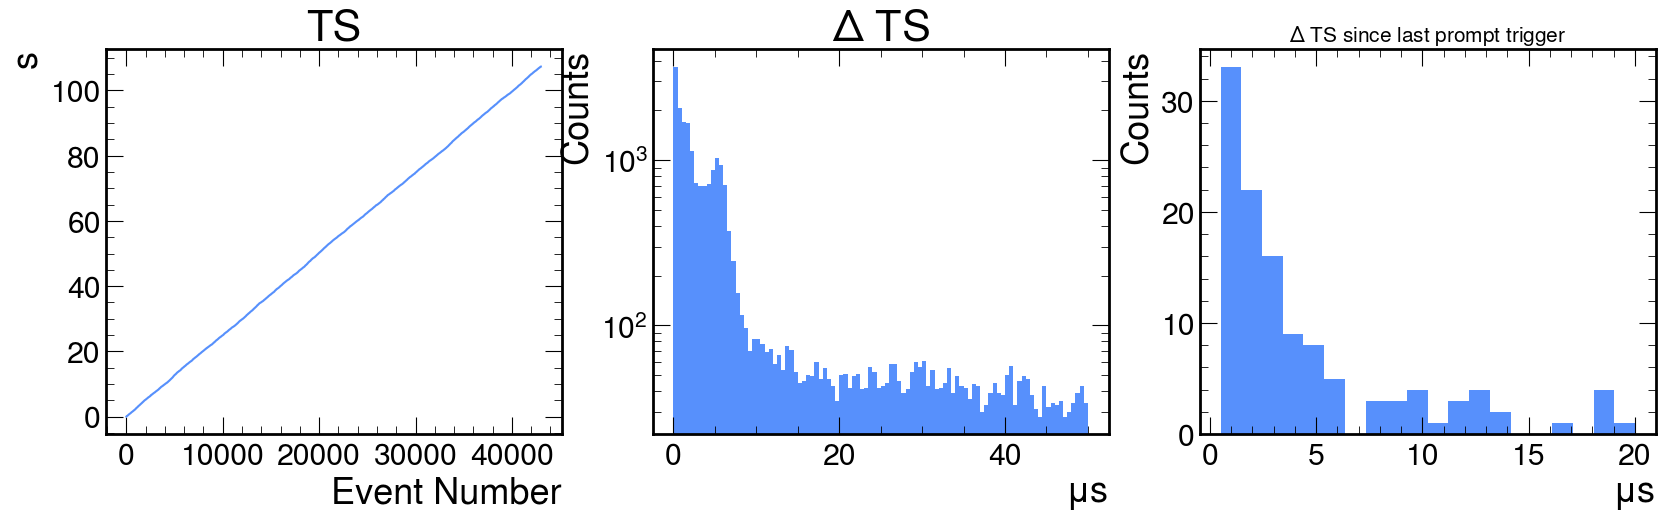

In [91]:
ts = [(event.timestamp-run.events[0].timestamp)/1e9 for event in run.events]
tslt = [event.time_since_last_trigger for event in run.events]
ptslpt = [event.time_since_last_prompt_trigger for event in run.events if event.trigger_type==0]
ftslpt = [event.time_since_last_prompt_trigger for event in run.events if event.trigger_type==1]


fig,ax=plt.subplots(1,3,figsize=(20,5))

ax[0].plot(ts)
ax[0].set_xlabel('Event Number')
ax[0].set_ylabel('s')
ax[0].set_title('TS')

ax[1].hist(tslt,bins=100,range=(0,50))
ax[1].set_ylabel('Counts')
ax[1].set_xlabel('$\mu$s')
ax[1].set_yscale('log')
ax[1].set_title('$\Delta$ TS')

ax[2].hist(ftslpt,bins=20,range=(0.5,20))
ax[2].set_ylabel('Counts')
ax[2].set_xlabel('$\mu$s')
# ax[2].set_yscale('log')
ax[2].set_title('$\Delta$ TS since last prompt trigger',fontsize=15)

Fit results:
A = 235.137 ± 26.615
tau = 2.321 ± 0.352
B = 2.139 ± 0.486
Chi2 = 11.011
Chi2/dof = 0.918


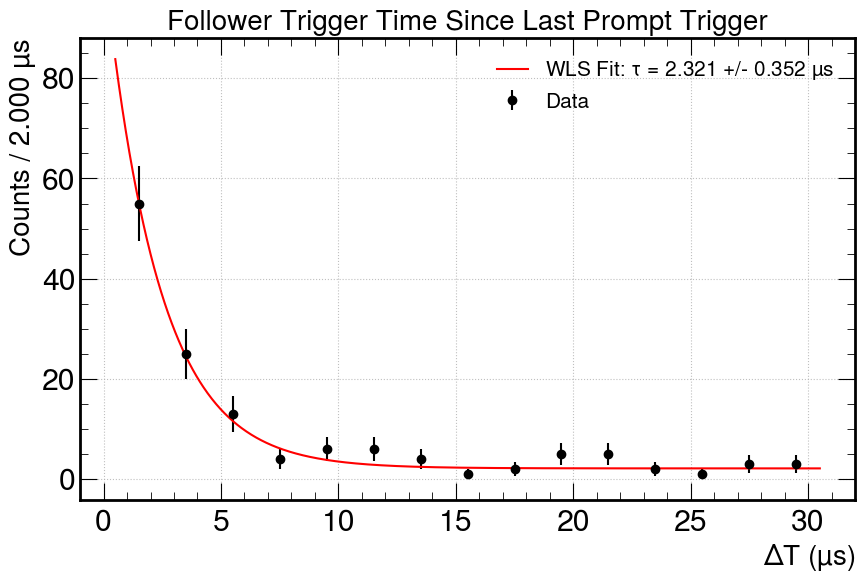

In [105]:
def fit_decay_hist(data,title,bins=15,range=(0.5,30.5),tau_guess=2):

    counts, bin_edges = np.histogram(data, bins=bins, range=range)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    sigma = np.sqrt(counts)

    def decay_model(t, A, tau, B):
        return (A / tau) * np.exp(-t / tau) + B
    
    # Initial guess for the parameters
    A_guess = np.max(counts) * (range[1] - range[0]) / bins
    B_guess = np.min(counts)
    p0 = [A_guess, tau_guess, B_guess]

    popt, pcov = curve_fit(decay_model, bin_centers, counts, sigma=sigma, absolute_sigma=True, p0=p0, maxfev=100000) 

    A_fit, tau_fit, B_fit = popt
    A_err, tau_err, B_err = np.sqrt(np.diag(pcov))

    residuals = counts - decay_model(bin_centers, *popt)
    chi2 = np.sum((residuals / sigma) ** 2)
    dof = len(counts) - len(popt)
    chi2_red = chi2 / dof

    print("Fit results:")
    print(f"A = {A_fit:.3f} ± {A_err:.3f}")
    print(f"tau = {tau_fit:.3f} ± {tau_err:.3f}")
    print(f"B = {B_fit:.3f} ± {B_err:.3f}")
    print(f"Chi2 = {chi2:.3f}")
    print(f"Chi2/dof = {chi2_red:.3f}")

    plt.figure(figsize=(10, 6))
    plt.errorbar(bin_centers, counts, yerr=sigma, fmt='o', color='black', label='Data')
    t_fine = np.linspace(*range, 1000)
    plt.plot(t_fine, decay_model(t_fine, *popt), color='red', label=fr'WLS Fit: $\tau$ = {tau_fit:.3f} +/- {tau_err:.3f} µs')
    plt.xlabel('$\Delta$T (µs)', fontsize=20)
    plt.ylabel(f"Counts / {(range[-1]-range[0])/bins:.3f} µs",fontsize=20)
    plt.title(title,fontsize=20)
    plt.grid(True)
    #plt.yscale('log')
    #plt.axvspan(0.5,3, color='blue', alpha=0.5, label='Selected Events')
    plt.legend(fontsize=15)
    plt.show()
    

fit_decay_hist(ftslpt,"Follower Trigger Time Since Last Prompt Trigger")


([<matplotlib.axis.YTick at 0x7231d964f190>,
 [Text(0, 0, '0'),
  Text(0, 50, '50'),
  Text(0, 100, '100'),
  Text(0, 150, '150')])

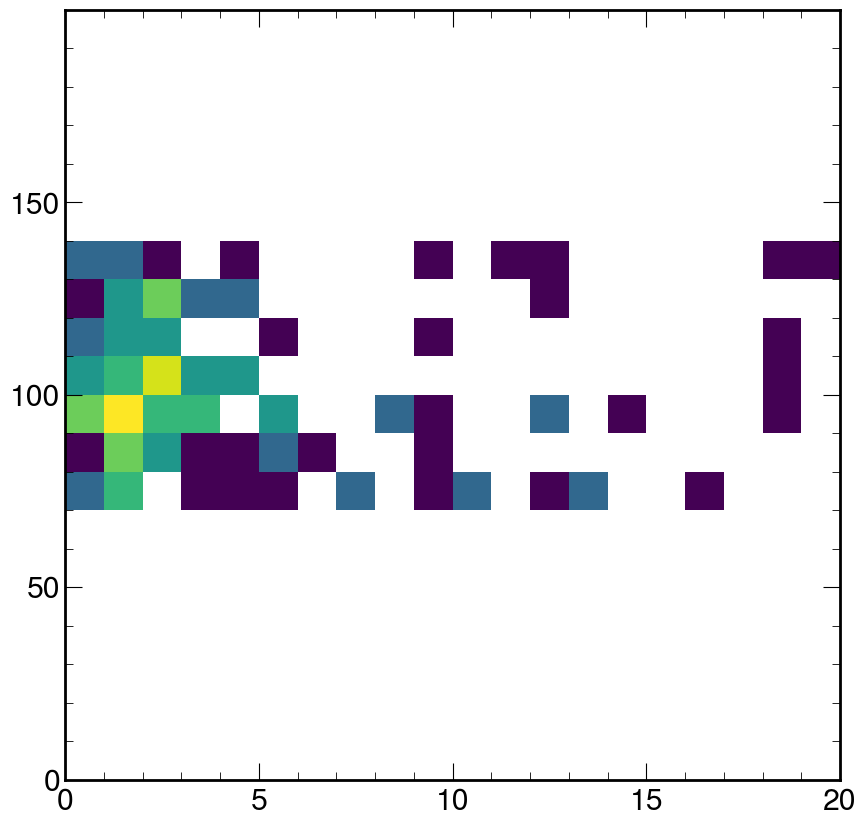

In [95]:


ftslpt_nhit = [len(event.hit_charge[event.good_channel_mask==1]) for event in run.events if event.trigger_type==1]

plt.hist2d(ftslpt,ftslpt_nhit,bins=(20,20),range=((0,20),(0,200)),norm='log')
plt.xticks(np.arange(0,21,5));
plt.yticks(np.arange(0,200,50))



In [96]:


# all = [event for event in run.events]# if event.trigger_type==1 and event.time_since_last_prompt_trigger<4 and np.sum(event.hit_charge)<500]

# rat =[]
# charge = []
# for event in all:
#     for i, wf in enumerate(event.waveforms):
#         if i in event.hit_id:
#             rat.append((np.median(wf)-np.min(wf))/(np.max(wf)-np.median(wf)))
#     for i, hc in enumerate(event.hit_charge):
#         charge.append(hc)


In [97]:
# charge_threshold=0.8
# ratio_threshold=2

# fig,ax = plt.subplots(1,3,figsize=(30,5))
# ax[0].hist(charge,bins=100,range=(-3,5))
# ax[0].axvline(charge_threshold,color='red')
# ax[1].hist(rat,bins=100,range=(0,10))
# ax[1].axvline(ratio_threshold,color='red')
# ax[1].set_yscale('log')
# ax[2].hist2d(charge,rat,bins=(100,100),range=((-5,5),(0,10)),norm='log');
# ax[2].axvline(charge_threshold,color='red')
# ax[2].axhline(ratio_threshold,color='red')


In [124]:
followers = [event for event in run.events if event.trigger_type==1]
michels = [event for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger<4]

print(len(michels))
#bad_michels = [event for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger<4 and np.sum(event.hit_charge)<100]

high_nhit = [event for event in run.events if len(event.hit_charge[event.good_channel_mask==1])>190]
high_charge = [event for event in run.events if np.sum(event.hit_charge[event.good_channel_mask==1])>11000]

#ringing = [event for event in run.events if event.trigger_type==1 and 20<ak.sum(event.good_channel_mask)<30 and 5<event.time_since_last_prompt_trigger<5.5]

79


79


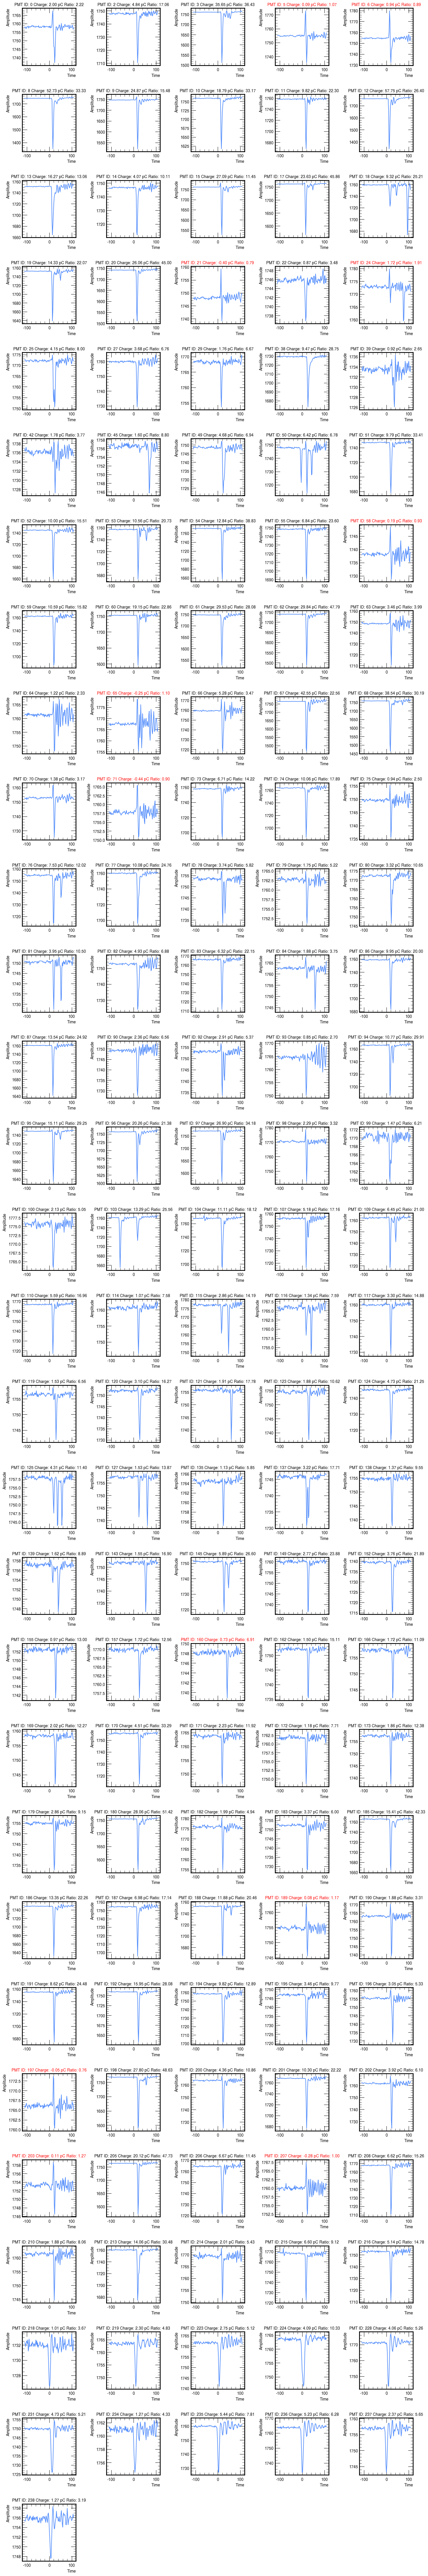

In [106]:


def plot_event_waveforms(events, event_id, columns=5):
    print(len(events))
    event = events[event_id]  
    waveforms = event.waveforms
    charges = event.hit_charge
    hit_ids = event.hit_id
    mask = event.good_channel_mask

    rows = (len(hit_ids) + columns - 1) // columns  # Calculate the number of rows

    vres=2000/pow(2,14)
    time=np.arange(-110,110,2)
    fontsize=10

    fig, axes = plt.subplots(rows, columns, figsize=(15, rows * 3))
    axes = axes.flatten()  # Flatten the axes for easy indexing
    for i, wf in enumerate(waveforms):
        charge_value=None
        if i in hit_ids:
            charge_index = ak.where(hit_ids==i)
            charge_value = charges[charge_index]
            val = (np.median(wf)-np.min(wf))/(np.max(wf)-np.median(wf))
            title = f"PMT ID: {i} Charge: {charge_value[0]:.2f} pC Ratio: {val:.2f}"
            j = charge_index[0][0]
            axes[j].plot(time,wf*vres)
            #axes[j].axhline(np.median(wf)*vres,color='red')
            if mask[j]==1:  
                axes[j].set_title(title,fontsize=fontsize)
            else:
                axes[j].set_title(title,fontsize=fontsize,color='red')
            axes[j].set_xlabel("Time",fontsize=fontsize)
            axes[j].set_ylabel("Amplitude",fontsize=fontsize)
            axes[j].tick_params(axis='both', which='major', labelsize=fontsize)  # Update tick label font size
            axes[j].tick_params(axis='both', which='minor', labelsize=fontsize)

    # Hide unused subplots
    for j in range(len(hit_ids), len(axes)):
        axes[j].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_event_waveforms(michels,2)

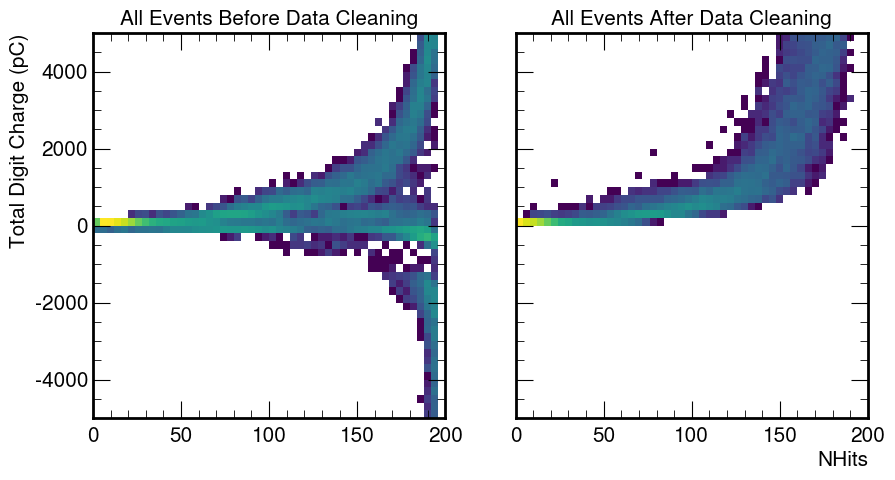

In [107]:
# Classic plot for all events

total_charge = [np.sum(event.hit_charge) for event in run.events]
nhits = [len(event.hit_charge) for event in run.events]

cleaned_total_charge = [np.sum(event.hit_charge[event.good_channel_mask==1]) for event in run.events]
cleaned_nhits = [len(event.hit_charge[event.good_channel_mask==1]) for event in run.events]

fontsize=15

fig,ax=plt.subplots(1,2,figsize=(10,5),sharey=True)
ax[0].hist2d(nhits,total_charge,bins=(50,50),range=((0,200),(-5000,5000)),norm='log')
ax[0].set_title(f"All Events Before Data Cleaning",fontsize=fontsize)
ax[0].set_ylabel('Total Digit Charge (pC)',fontsize=fontsize)
ax[0].tick_params(axis='both', which='major', labelsize=fontsize)  # Update tick label font size

ax[1].hist2d(cleaned_nhits,cleaned_total_charge,bins=(50,50),range=((0,200),(-5000,5000)),norm='log')
ax[1].set_title(f"All Events After Data Cleaning",fontsize=fontsize)
ax[1].set_xlabel('NHits',fontsize=fontsize)
ax[1].tick_params(axis='both', which='major', labelsize=fontsize)



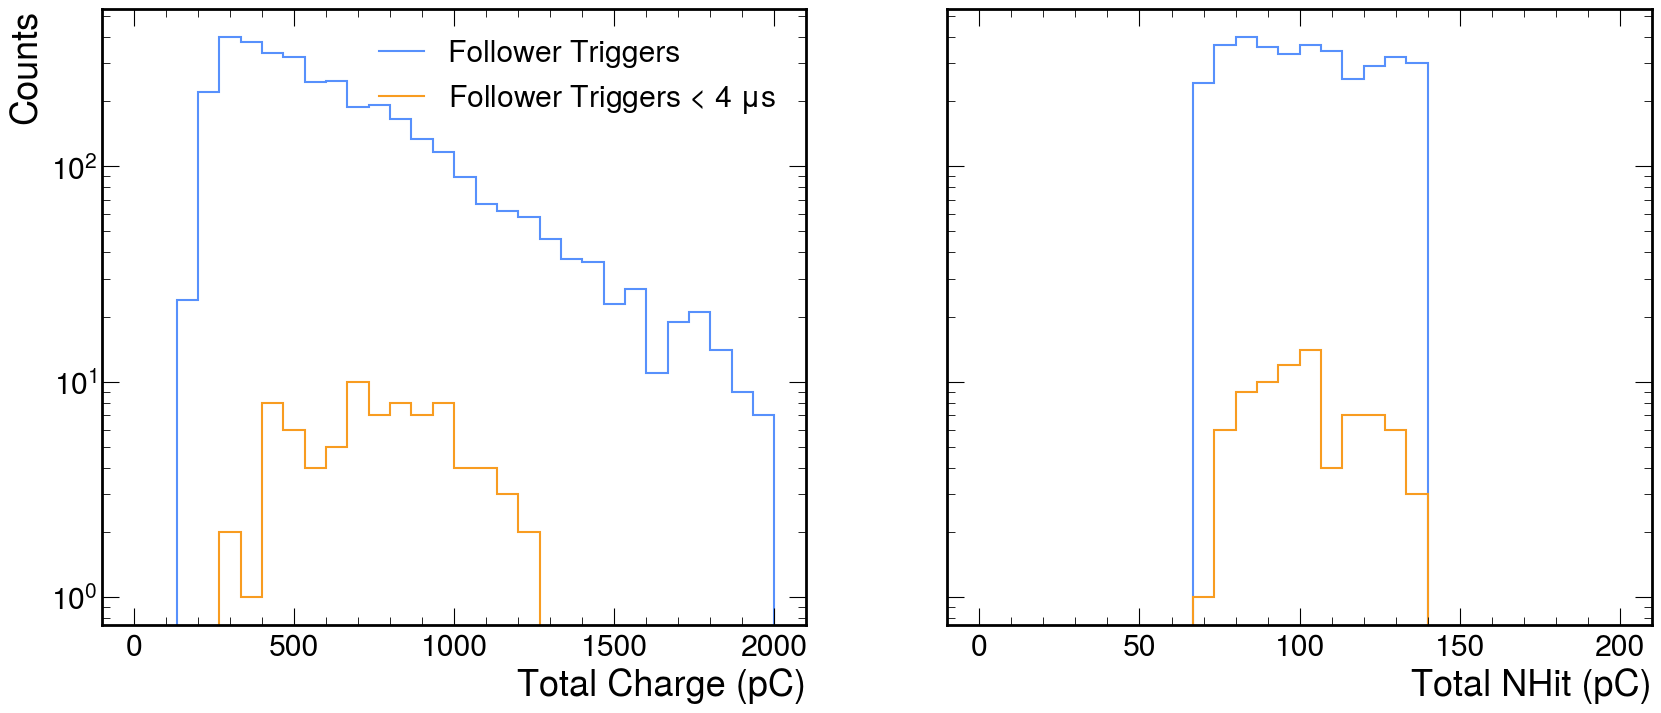

In [109]:



all_followers = [event for event in run.events if event.trigger_type==1]
all_prompt_followers = [event for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger<4]

af_total_charge = [np.sum(event.hit_charge[event.good_channel_mask==1]) for event in all_followers]
apf_total_charge = [np.sum(event.hit_charge[event.good_channel_mask==1]) for event in all_prompt_followers]

af_nhits = [ak.sum(event.good_channel_mask==1) for event in all_followers]
apf_nhits = [ak.sum(event.good_channel_mask==1) for event in all_prompt_followers]

fig,ax=plt.subplots(1,2,figsize=(20,8),sharey=True)
hep.histplot(np.histogram(af_total_charge,bins=30,range=(0,2000)),ax=ax[0],label="Follower Triggers")
hep.histplot(np.histogram(apf_total_charge,bins=30,range=(0,2000)),ax=ax[0],label="Follower Triggers < 4 $\mu$s")
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('Total Charge (pC)')
ax[0].set_yscale('log')
ax[0].legend(loc='upper right')
hep.histplot(np.histogram(af_nhits,bins=30,range=(0,200)),ax=ax[1],label="Follower Triggers")
hep.histplot(np.histogram(apf_nhits,bins=30,range=(0,200)),ax=ax[1],label="Follower Triggers < 4 $\mu$s")
ax[1].set_xlabel('Total NHit (pC)')
ax[1].set_yscale('log')



18 groups


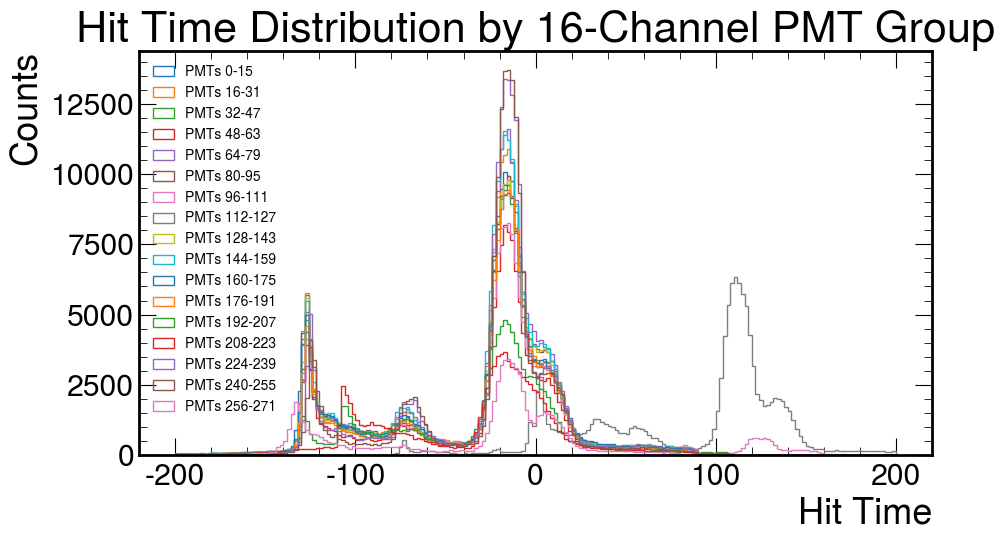

In [111]:
id2ch = dict(zip(run.pmt_id, run.pmt_ch))
ch2id = dict(zip(run.pmt_ch, run.pmt_id))

grouped_hit_times = {}

for event in run.events:
    for pmt_id, time in zip(event.hit_id, event.hit_time):
        if True: #run.pmt_is_online[pmt_id]:#and -30<time<10:
            group = id2ch[pmt_id] // 16
            if group not in grouped_hit_times:
                grouped_hit_times[group] = []
            grouped_hit_times[group].append(time)

# Convert to NumPy array if needed
for group in grouped_hit_times:
    grouped_hit_times[group] = np.array(grouped_hit_times[group])

plt.figure(figsize=(10, 6))

colors = plt.cm.tab10.colors  # color palette
for i, (group, times) in enumerate(sorted(grouped_hit_times.items())):
    plt.hist(times, bins=200, range=(-200,200), histtype='step', label=f'PMTs {group*16}-{group*16+15}', color=colors[i % len(colors)])

plt.xlabel('Hit Time')
plt.ylabel('Counts')
plt.legend(fontsize=10)
plt.title('Hit Time Distribution by 16-Channel PMT Group')
plt.tight_layout()

print(f"{len(grouped_hit_times)+1} groups")


plt.show()

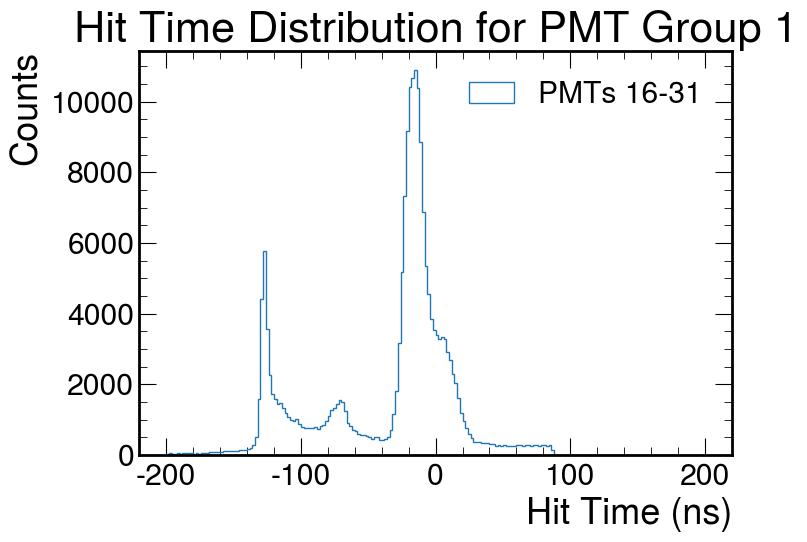

In [112]:
group_to_plot = 1 # Change this to whichever group you want

if group_to_plot in grouped_hit_times:
    plt.figure(figsize=(8, 6))
    times = grouped_hit_times[group_to_plot]
    plt.hist(times, bins=200, range=(-200, 200), histtype='step', 
             label=f'PMTs {group_to_plot*16}-{group_to_plot*16+15}',
             color='tab:blue')
    
    plt.xlabel('Hit Time (ns)')
    plt.ylabel('Counts')
    plt.title(f'Hit Time Distribution for PMT Group {group_to_plot}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Group {group_to_plot} not found in data.")

In [113]:
channel_hit_times = {}

for event in run.events:
    for pmt_id, time in zip(event.hit_id, event.hit_time):
        # Can do sorting here. Should really put back into class
        if True:
            channel = id2ch[pmt_id] 
            if channel not in channel_hit_times:
                channel_hit_times[channel] = []
            channel_hit_times[channel].append(time)

# Convert to NumPy array if needed
for channel in channel_hit_times:
    channel_hit_times[channel] = np.array(channel_hit_times[channel])



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


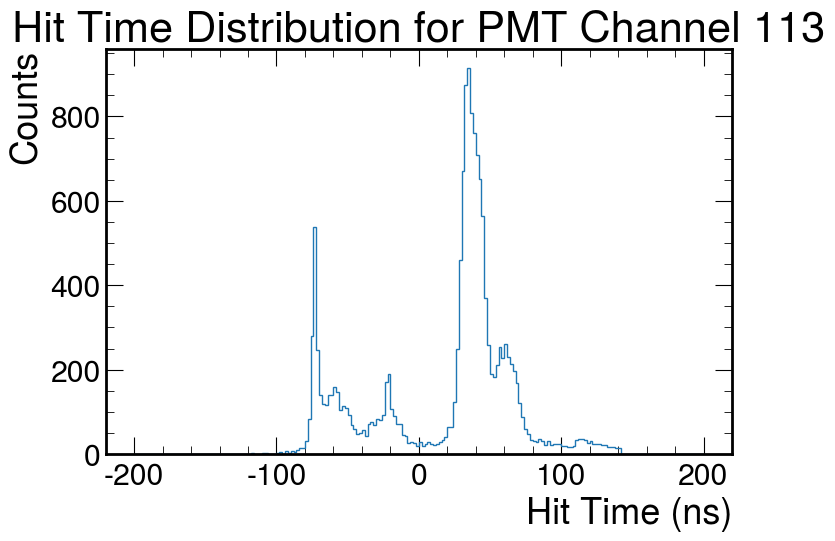

In [114]:
id2ch = dict(zip(run.pmt_id, run.pmt_ch))
ch2id = dict(zip(run.pmt_ch, run.pmt_id))

channel_to_plot =113 # Change this to whichever group you want

if channel_to_plot in channel_hit_times:
    plt.figure(figsize=(8, 6))
    times = channel_hit_times[channel_to_plot]
    plt.hist(times, bins=200, range=(-200, 200), histtype='step',
             color='tab:blue')
    
    plt.xlabel('Hit Time (ns)')
    plt.ylabel('Counts')
    plt.title(f'Hit Time Distribution for PMT Channel {channel_to_plot}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Channel {channel_to_plot} not found in data.")
    print(f"Channel Online: {run.pmt_is_online[ch2id[channel_to_plot]]}")

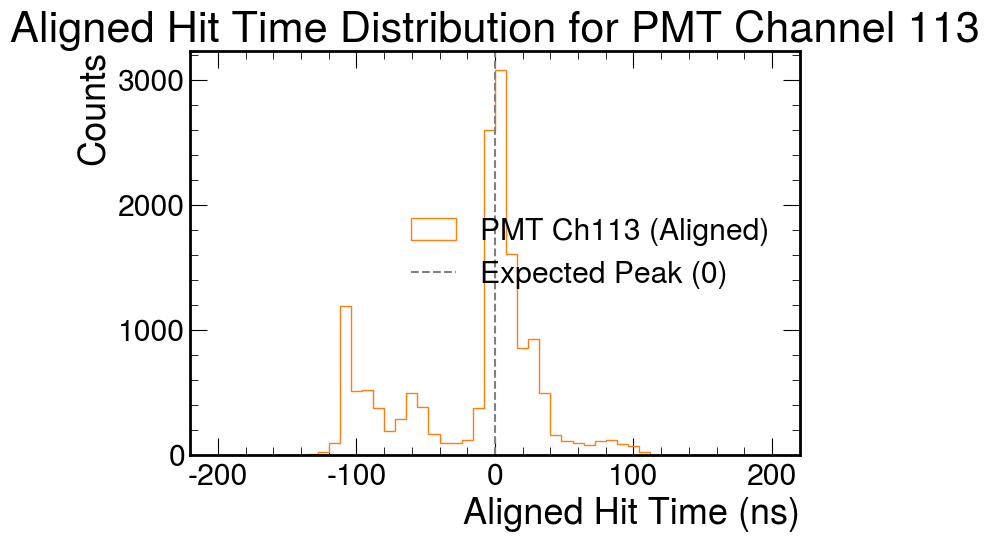

dict_keys([np.int32(224), np.int32(226), np.int32(113), np.int32(227), np.int32(230), np.int32(231), np.int32(232), np.int32(233), np.int32(234), np.int32(235), np.int32(241), np.int32(242), np.int32(243), np.int32(244), np.int32(119), np.int32(245), np.int32(246), np.int32(247), np.int32(249), np.int32(250), np.int32(258), np.int32(261), np.int32(267), np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(13), np.int32(14), np.int32(22), np.int32(24), np.int32(26), np.int32(32), np.int32(33), np.int32(37), np.int32(41), np.int32(42), np.int32(46), np.int32(54), np.int32(58), np.int32(65), np.int32(66), np.int32(70), np.int32(71), np.int32(75), np.int32(76), np.int32(77), np.int32(188), np.int32(80), np.int32(81), np.int32(83), np.int32(85), np.int32(86), np.int32(93), np.int32(96), np.int32(98), np.int32(100), np.int32(102), np.int32(103), np.int32(105), np.int32(106), np.int32(190), np.int32(133), np.int32(135), np.int32(138), np.int32(139), np.int32(140), np.int32(141), np.in

In [ ]:
cable_delays = {}  # Dictionary to store delay per PMT
aligned_channel_hit_times = {}  # Store corrected hit times

def compute_cable_delays(channel_hit_times, bins=200, range=(-200, 200)):
    for pmt_ch, times in channel_hit_times.items():
        # Compute histogram
        counts, bin_edges = np.histogram(times, bins=bins, range=range)
        
        # Find the bin with the max count
        max_bin_index = np.argmax(counts)
        
        # Compute the center of that bin
        bin_center = 0.5 * (bin_edges[max_bin_index] + bin_edges[max_bin_index + 1])
        
        # Store delay
        cable_delays[pmt_ch] = bin_center
        
        # Apply delay correction to hit times
        aligned_channel_hit_times[pmt_ch] = times - bin_center

    return cable_delays

compute_cable_delays(channel_hit_times)

# Plot an aligned histogram to verify peak is at 0
def plot_aligned_channel(pmt_ch):
    if pmt_ch in aligned_channel_hit_times:
        plt.figure(figsize=(8, 6))
        times = aligned_channel_hit_times[pmt_ch]
        plt.hist(times, bins=50, range=(-200, 200), histtype='step', 
                 label=f'PMT Ch{pmt_ch} (Aligned)', color='tab:orange')
        plt.xlabel('Aligned Hit Time (ns)')
        plt.ylabel('Counts')
        plt.title(f'Aligned Hit Time Distribution for PMT Channel {pmt_ch}')
        plt.axvline(0, color='gray', linestyle='--', label='Expected Peak (0)')
        plt.legend()
        plt.tight_layout()
        # plt.yscale('log')
        plt.show()
    else:
        print(f"PMT {pmt_ch} not found in aligned data.")

# Try it
plot_aligned_channel(113)

print(cable_delays.keys())

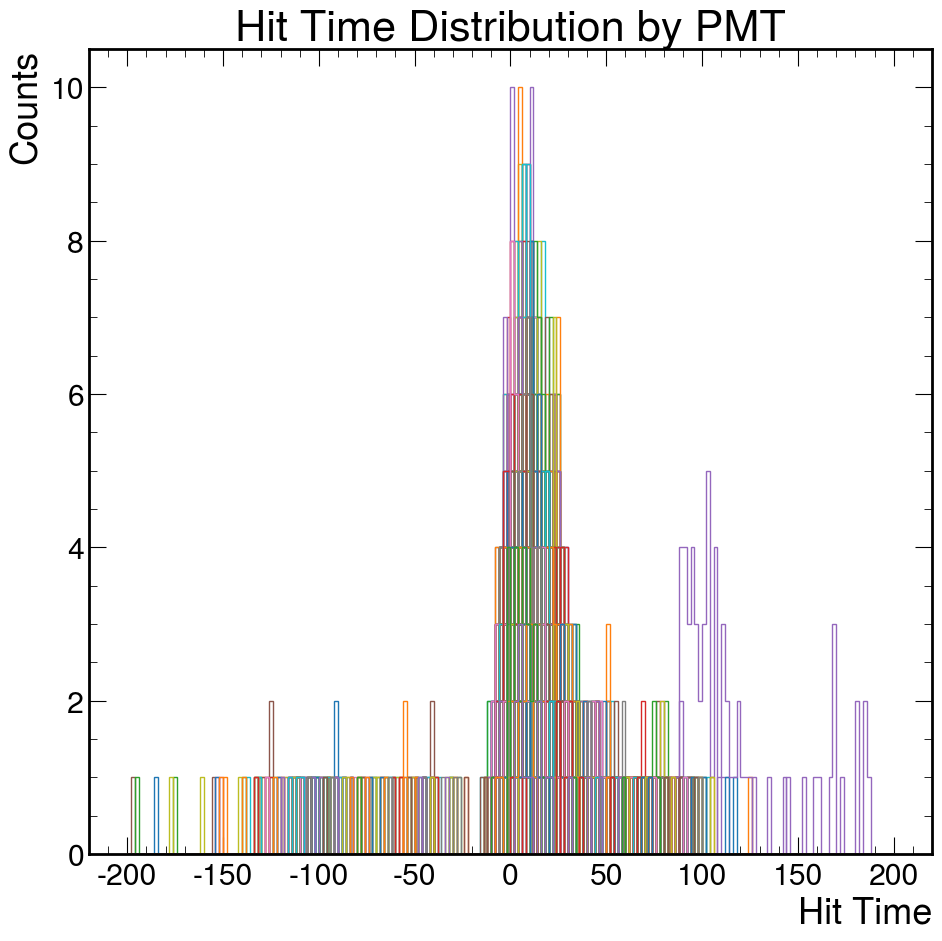

In [117]:
corrected_channel_hit_times = {}

for event in michels:
    for pmt_id, time in zip(event.hit_id, event.hit_time):
        # Can do sorting here. Should really put back into class
        if True:#-500<event.xquad<500 and -500<event.yquad<500 and -500<event.zquad<500:
            channel = id2ch[pmt_id] 
            if channel not in corrected_channel_hit_times:
                corrected_channel_hit_times[channel] = []
            if channel not in cable_delays:
                print(f"Channel {channel} not found in cable delays")
                cable_delays[channel] = 0
            corrected_channel_hit_times[channel].append(time-cable_delays[channel])

# Convert to NumPy array if needed
for channel in corrected_channel_hit_times:
    corrected_channel_hit_times[channel] = np.array(corrected_channel_hit_times[channel])

plt.figure(figsize=(10, 10))

colors = plt.cm.tab10.colors  # color palette
for i, (channel, times) in enumerate(sorted(corrected_channel_hit_times.items())):
    plt.hist(times, bins=200, range=(-200,200), histtype='step', label=f'PMTs {channel}', color=colors[i % len(colors)])

plt.xlabel('Hit Time')
plt.ylabel('Counts')
#plt.legend()
plt.title('Hit Time Distribution by PMT')
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


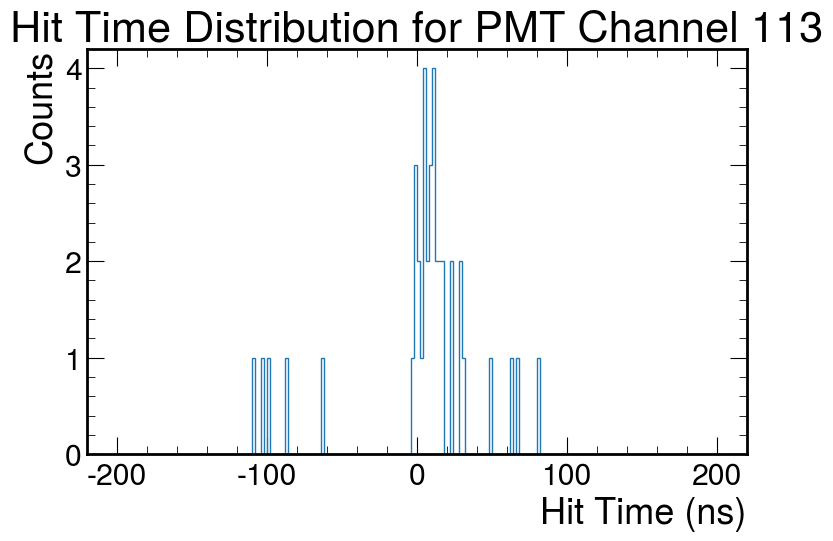

In [118]:
id2ch = dict(zip(run.pmt_id, run.pmt_ch))
ch2id = dict(zip(run.pmt_ch, run.pmt_id))

channel_to_plot =113 # Change this to whichever group you want

if channel_to_plot in corrected_channel_hit_times:
    plt.figure(figsize=(8, 6))
    times = corrected_channel_hit_times[channel_to_plot]
    plt.hist(times, bins=200, range=(-200, 200), histtype='step',
             color='tab:blue')
    
    plt.xlabel('Hit Time (ns)')
    plt.ylabel('Counts')
    plt.title(f'Hit Time Distribution for PMT Channel {channel_to_plot}')
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print(f"Channel {channel_to_plot} not found in data.")
    print(f"Channel Online: {run.pmt_is_online[ch2id[channel_to_plot]]}")

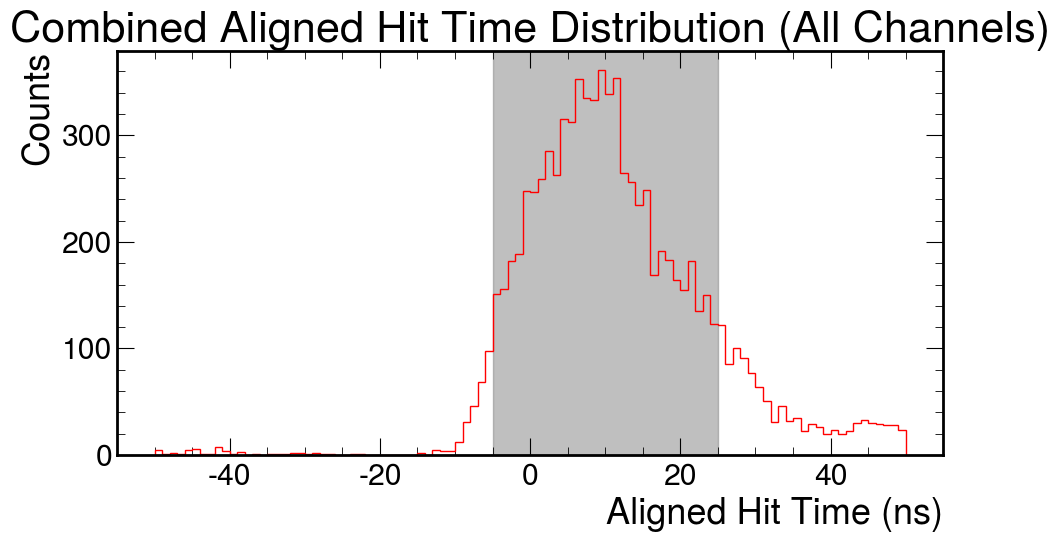

In [120]:

# Combine all aligned times into one array
all_corrected_times = np.concatenate(list(corrected_channel_hit_times.values()))

# Plot the combined histogram
plt.figure(figsize=(10, 6))
plt.hist(all_corrected_times, bins=100, range=(-50, 50), histtype='step', edgecolor='red')
plt.axvspan(-5,25,color='grey',alpha=0.5)
plt.xlabel('Aligned Hit Time (ns)')
plt.ylabel('Counts')
plt.title('Combined Aligned Hit Time Distribution (All Channels)')
plt.tight_layout()
plt.show()

In [121]:

# Define PMT channels
barrel_boards = [0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11]
barrel_channels = [16 * board + i for board in barrel_boards for i in range(16)]


special_channels = np.arange(0, 36, 1)

top_boards =  [12, 13]
top_channels = [16 * board + i for board in top_boards for i in range(16)]

dichroic_boards = [7]
dichroic_channels = [16 * board + i for board in dichroic_boards for i in range(16)]

bottom_boards = [14, 15]
bottom_channels = [16 * board + i for board in bottom_boards for i in range(16)]

behind_boards = [16]
behind_channels = [16 * board + i for board in behind_boards for i in range(13)]

# Create channel to ID mapping
ch2id = dict(zip(run.pmt_ch, run.pmt_id))

# Convert channel lists to ID lists
barrel_ids = [ch2id[ch] for ch in barrel_channels if ch in ch2id]
bottom_ids = [ch2id[ch] for ch in bottom_channels if ch in ch2id]
dichroic_ids = [ch2id[ch] for ch in dichroic_channels if ch in ch2id]
special_ids = [ch2id[ch] for ch in special_channels if ch in ch2id]
top_ids = [ch2id[ch] for ch in top_channels if ch in ch2id]
behind_ids = [ch2id[ch] for ch in behind_channels if ch in ch2id]


268
79


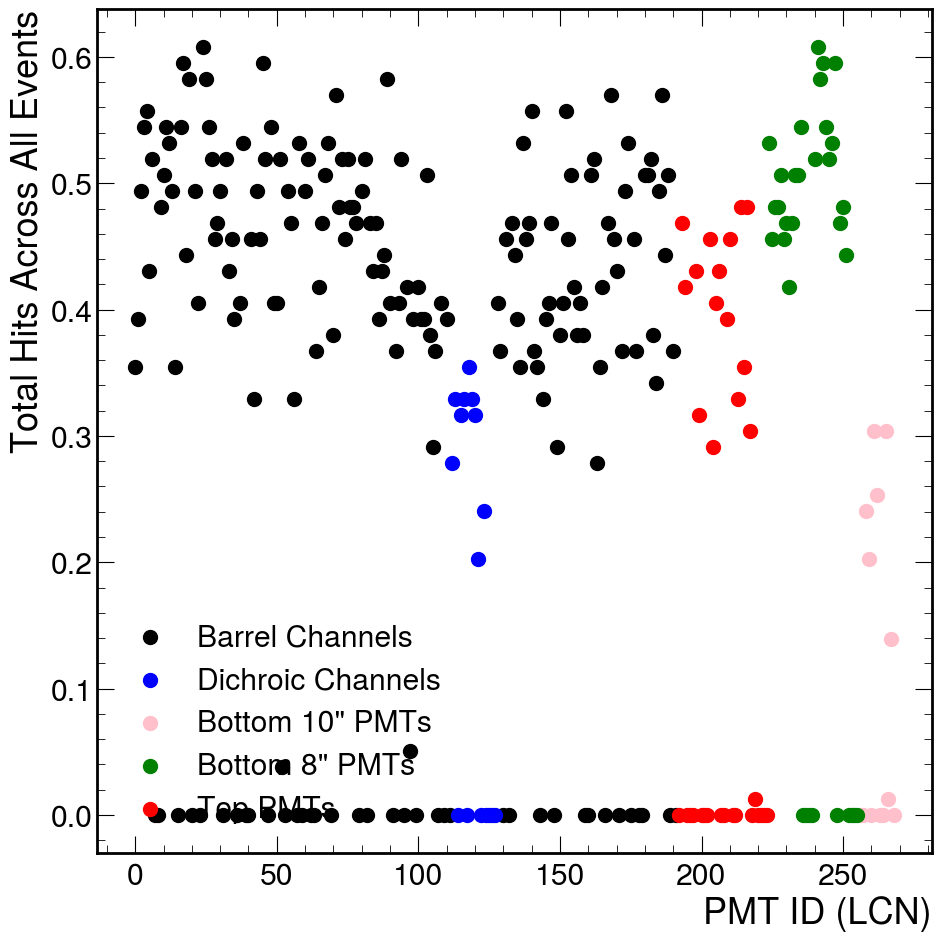

In [128]:
pmt_id_to_ch = dict(zip(run.pmt_id, run.pmt_ch))

# Assuming each PMT ID maps directly to its LCN (i.e., pmt_id == lcn)
pmt_hit_counts = np.zeros(np.max(run.pmt_ch)+1, dtype=int)

# Count hits for online PMTs
for i, (pmt_ch, times) in enumerate(sorted(corrected_channel_hit_times.items())):
    cut_times = []
    for time in times:
        if -20<time<20:
            pmt_hit_counts[pmt_ch] += 1

print(np.max(run.pmt_ch))

coinc_hit_counts = pmt_hit_counts / len(michels)
print(len(michels))

# Plot
plt.figure(figsize=(10, 10))
#plt.scatter(range(len(pmt_hit_counts)), coinc_hit_counts, s=100, alpha=0.5, color='black')

# Optional: highlight barrel and dichroic
plt.scatter(barrel_channels, coinc_hit_counts[barrel_channels], s=100, alpha=1, color='black', label='Barrel Channels')
plt.scatter(dichroic_channels, coinc_hit_counts[dichroic_channels], s=100, alpha=1, color='blue', label='Dichroic Channels')
plt.scatter(behind_channels, coinc_hit_counts[behind_channels], s=100, alpha=1, color='pink', label='Bottom 10" PMTs')
plt.scatter(bottom_channels, coinc_hit_counts[bottom_channels], s=100, alpha=1, color='green', label='Bottom 8" PMTs')
plt.scatter(top_channels, coinc_hit_counts[top_channels], s=100, alpha=1, color='red', label='Top PMTs')

plt.xlabel("PMT ID (LCN)")
plt.ylabel("Total Hits Across All Events")
plt.legend(loc='lower left')
#plt.ylim(np.max(pmt_hit_counts)/2,2*np.max(pmt_hit_counts))
plt.tight_layout()


Dichroic avg: 0.001 ± 0.000 hits/event
Bottom 8" avg: 0.001 ± 0.000 hits/event
Ratio (dichroic/bottom): 0.59 ± 0.05


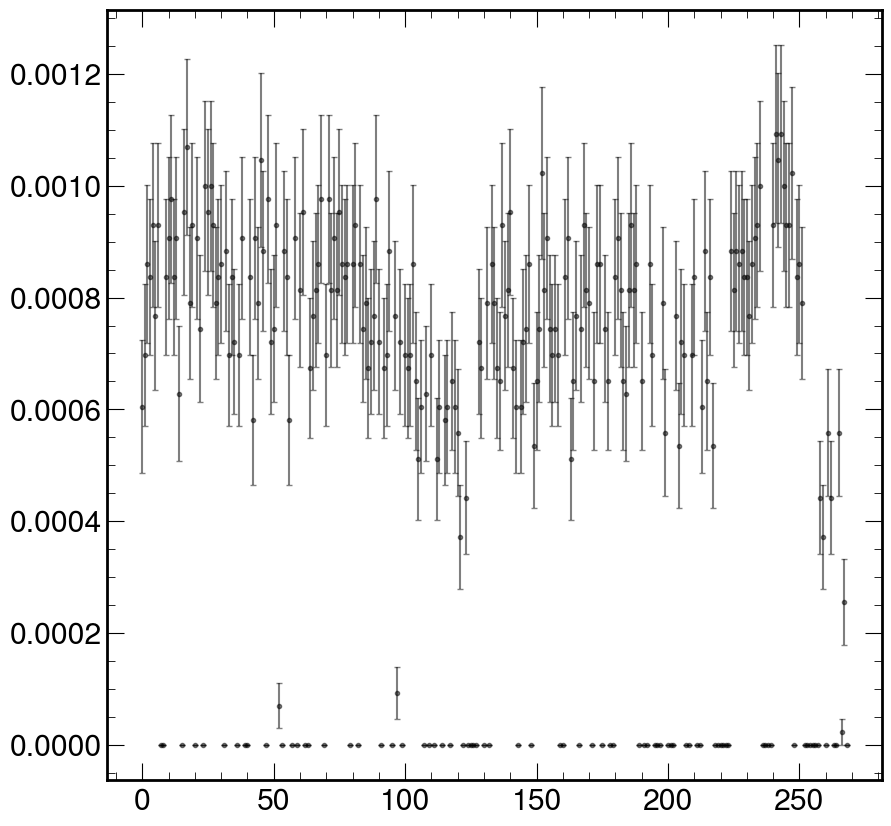

In [126]:
import numpy as np
from uncertainties import ufloat  # Requires `uncertainties` package (pip install uncertainties)

# Convert hit counts to rates and propagate Poisson errors
pmt_hit_rates = []
pmt_hit_errors = []

for count in pmt_hit_counts:
    # For each PMT: rate = count / N_events, with uncertainty √count / N_events
    N_events = len(run.events)
    rate = count / N_events
    error = np.sqrt(count) / N_events  # Poisson error propagation
    pmt_hit_rates.append(rate)
    pmt_hit_errors.append(error)

# Convert to numpy arrays
pmt_hit_rates = np.array(pmt_hit_rates)
pmt_hit_errors = np.array(pmt_hit_errors)

# Plot with error bars
plt.errorbar(
    x=np.arange(len(pmt_hit_rates)),
    y=pmt_hit_rates,
    yerr=pmt_hit_errors,
    fmt='o',
    markersize=3,
    capsize=2,
    alpha=0.5,
    color='black',
    label='PMT hit rates ± 1σ'
)

def weighted_average_with_uncertainty(rates, errors):
    """Calculate weighted average and its uncertainty."""
    weights = 1 / (errors ** 2)
    avg = np.sum(weights * rates) / np.sum(weights)
    err = 1 / np.sqrt(np.sum(weights))
    return avg, err

# Dichroic channels
dichroic_rates = pmt_hit_rates[dichroic_channels]
dichroic_errors = pmt_hit_errors[dichroic_channels]
avg_dichroic, err_dichroic = weighted_average_with_uncertainty(
    dichroic_rates[dichroic_rates > 0.0001],
    dichroic_errors[dichroic_rates > 0.0001]
)

# Bottom 8" channels
bottom_rates = pmt_hit_rates[bottom_channels]
bottom_errors = pmt_hit_errors[bottom_channels]
avg_bottom, err_bottom = weighted_average_with_uncertainty(
    bottom_rates[bottom_rates > 0.0001],
    bottom_errors[bottom_rates > 0.0001]
)

print(f"Dichroic avg: {avg_dichroic:.3f} ± {err_dichroic:.3f} hits/event")
print(f"Bottom 8\" avg: {avg_bottom:.3f} ± {err_bottom:.3f} hits/event")

R = avg_dichroic / avg_bottom
R_err = R * np.sqrt((err_dichroic/avg_dichroic)**2 + (err_bottom/avg_bottom)**2)

print(f"Ratio (dichroic/bottom): {R:.2f} ± {R_err:.2f}")


In [ ]:




charge = [event.total_digit_charge_pc for event in run.events]
nhit = [event.nhits for event in run.events]

prompt_charge = [event.total_digit_charge_pc for event in run.events if event.trigger_type==0]
prompt_nhit = [event.nhits for event in run.events if event.trigger_type==0]

early_follower_charge = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]
early_follower_nhit = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]

late_follower_charge = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us >= 4]
late_follower_nhit = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us >= 4]

x = np.linspace(0,200,100)

fig, ax = plt.subplots(1,4, figsize=(15,5))
fig.tight_layout()
hep.hist2dplot(np.histogram2d(nhits, charge, bins=(200,200), range=((0,200),(0,15000))), ax=ax[0], norm='log')
ax[0].set_title("All Triggers")
#ax[0].plot(x,line(x,0.022,108,90),'-',linewidth=2,color='red')

hep.hist2dplot(np.histogram2d(prompt_nhit, prompt_charge, bins=(200,200), range=((0,200),(0,15000))), ax=ax[1], norm='log')
ax[1].set_title("Prompt Triggers")
ax[1].set_xlabel("NHits")
ax[1].set_ylabel("Charge (pc)")

hep.hist2dplot(np.histogram2d(early_follower_nhit, early_follower_charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[2], norm='log')
ax[2].set_title("Early Follower Triggers")
ax[2].set_xlabel("NHits")   
ax[2].set_ylabel("Charge (pc)")

hep.hist2dplot(np.histogram2d(late_follower_nhit, late_follower_charge, bins=(200,200), range=((0,200),(0,1500))), ax=ax[3], norm='log')
ax[3].set_title("Late Follower Triggers")
ax[3].set_xlabel("NHits")
ax[3].set_ylabel("Charge (pc)")

# Cut on nhit and charge aboce 100 nhit to isolate the three regions
# Top is prompt muons
# Bottoms is early michels
# What is middle? Late something

In [ ]:
# early_total_charge = [event.total_gaussian_charge_pc for event in run.events if event.time_since_last_trigger_us<3]
# late_total_charge = [event.total_gaussian_charge_pc for event in run.events if event.time_since_last_trigger_us>3]

# ec, eb = np.histogram(early_total_charge, bins=50, range=(0,500))
# lc, lb = np.histogram(late_total_charge, bins=50, range=(0,500))
# res = lc-ec
# centers = (eb[1:]+eb[:-1])/2

# plt.hist(early_total_charge, bins=50, range=(0,500), histtype='step', label='Early - Decaying Muon');
# plt.hist(late_total_charge, bins=50, range=(0,500), histtype='step', label='Late - Crossing Muon');
# plt.plot(centers, res, label='Difference',)
# plt.legend()
# plt.yscale('log')

In [ ]:
# for event in run.events:
#     event.print()

print(','.join(f"{bool}" for bool in run.pmt_is_online))


In [ ]:
nhits = run.get_nhits()

plt.figure(figsize=(10, 6))
hep.histplot(np.histogram(nhits, bins=200, range=(0, 200)), color='black')
plt.axvspan(prompt_nhit_range[0], prompt_nhit_range[1], color='red', alpha=0.5, label='Prompt Triggers')
plt.axvspan(follower_nhit_range[0], follower_nhit_range[1], color='blue', alpha=0.5, label='Follower Triggers')
plt.legend(loc='upper right',bbox_to_anchor=(1.45, 1),fontsize=20)
#plt.ylim(1e3,1e5)
plt.yscale('log')
plt.ylabel('Number of Events', fontsize=20)
plt.xlabel('Total NHits per Event', fontsize=20)

In [ ]:
ts_prompt = [event.timestamp_us for event in run.events if event.trigger_type==0]
ts_follower = [event.timestamp_us for event in run.events if event.trigger_type==1]
ts_bad = [event.timestamp_us for event in run.events if event.trigger_type==None]

deltat = [event.time_since_last_trigger_us for event in run.events if event.trigger_type==1]
deltat_follower = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1]
deltat_follower_early = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4 and event.n_negatives<10]
print(len(deltat),len(deltat_follower))

nhits_prompt = [event.nhits for event in run.events if event.trigger_type==0]
nhits_follower = [event.nhits for event in run.events if event.trigger_type==1]
nhits_bad = [event.nhits for event in run.events if event.trigger_type==None]

fig, ax = plt.subplots(1,2,figsize=(25, 10))
fig.tight_layout()
ax[0].plot(ts_prompt, nhits_prompt, 'o', markersize=5, label='prompt', color='red')
ax[0].plot(ts_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
ax[0].plot(ts_bad, nhits_bad, 'o', markersize=5, label='follower', color='black')
ax[0].set_xlabel('Timestamp (µs)', loc='center',fontsize=30)
ax[0].set_ylabel('Total NHits per Event', fontsize=30)
ax[0].set_xlim(0, 5e7)
ax[0].legend(loc='upper left',bbox_to_anchor=(-0.35, 1),fontsize=25)
#ax[1].plot(deltat_follower, nhits_follower, 'o', markersize=5, label='follower', color='blue')
hd = ax[1].hist2d(deltat_follower, nhits_follower, bins=(30, 30), range=((1, 20), (0,200)),norm='log', cmap='Blues')
ax[1].set_xlabel('Time Since Last Prompt Trigger (µs)', loc='center', fontsize=30)
ax[1].set_xlim(1,20)
#ax[1].set_ylim(follower_nhit_range[0], follower_nhit_range[1])  
fig.colorbar(hd[3],ax=ax[1])
#ax[2].plot(deltat, nhits_follower, 'o', markersize=5, label='follower', color='blue')
# hdf = ax[2].hist2d(deltat, nhits_follower, bins=(19, 20), range=((1, 20), (0, 200)), cmap='Blues')
# ax[2].set_xlabel('Time since last trigger (us)', fontsize=20)
# ax[2].set_xlim(1,20)
# fig.colorbar(hdf[3],ax=ax[2])

In [ ]:
plt.figure(figsize=(6, 4))
plt.hist(deltat, bins=40, range=(1, 20), histtype='step', label='Follower')
plt.hist(deltat_follower, bins=40, range=(1, 20), histtype='step', label='Follower');
plt.hist(deltat_follower_early, bins=40, range=(1,20),alpha=0.2)

In [ ]:
total_digit_charge_pc = [event.total_digit_charge_pc for event in run.events if event.trigger_type!=None] 
total_log_charge_pc = [event.total_log_charge_pc for event in run.events if event.trigger_type!=None]
total_gaussian_charge_pc = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type!=None]

print(len(total_log_charge_pc),len(total_digit_charge_pc), len(total_gaussian_charge_pc))
print(total_digit_charge_pc[0])
print(total_log_charge_pc[0])
print(total_digit_charge_pc[0])

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(30, 10),sharey=True,tight_layout=True)
fontsize = 25
bins=50
upper_charge=1500
nneg=10
#log_bins = np.logspace(np.log10(1),np.log10(upper_charge), bins)

total_log_charge_pc_follower_early = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.n_negatives<10]
total_log_charge_pc_follower_late = [event.total_log_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_log_charge_pc_prompt = [event.total_log_charge_pc for event in run.events if event.trigger_type==0]

ax[0].hist(total_log_charge_pc_follower_early, bins=bins, range=(0,600), histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[0].hist(total_log_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[0].hist(total_log_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[0].set_xlabel('Total Log Charge (pc)', fontsize=fontsize)
ax[0].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
#ax[0].set_xlim(3e1,1e4)
# ax[0].set_ylim(0,50)
#ax[0].legend()

total_gaussian_charge_pc_follower_early = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.n_negatives<10]
total_gaussian_charge_pc_follower_late = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_gaussian_charge_pc_prompt = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==0]

ax[1].hist(total_gaussian_charge_pc_follower_early, bins=bins, range=(0,600), histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[1].hist(total_gaussian_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[1].hist(total_gaussian_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[1].set_xlabel('Total Gaussian Charge (pc)', fontsize=fontsize)
ax[1].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
#ax[1].set_xlim(3e1,1e4)
# ax[1].set_ylim(0,50)
#ax[1].legend()

total_digit_charge_pc_follower_early = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.n_negatives<10]
total_digit_charge_pc_follower_late = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
total_digit_charge_pc_prompt = [event.total_digit_charge_pc for event in run.events if event.trigger_type==0]

ax[2].hist(total_digit_charge_pc_follower_early, bins=bins, histtype='step', label='Early Follower Triggers ($\Delta$T < 4 µs)');
#ax[2].hist(total_digit_charge_pc_follower_late, bins=bins, range=(0,upper_charge), histtype='step', label='Late Follower Triggers ($\Delta$T > 4 µs)');
#ax[2].hist(total_digit_charge_pc_prompt, bins=bins, range=(0,upper_charge), histtype='step', label='All Prompt Triggers');
ax[2].set_xlabel('Total Digit Charge (pc)', fontsize=fontsize)
ax[2].set_ylabel('Triggers per bin', fontsize=fontsize)
#ax[2].set_xlim(3e1,2e4)
#ax[2].set_xscale('log')
#ax[2].set_yscale('log')
# ax[2].set_ylim(0,50)
ax[2].legend(loc='upper left')

In [ ]:
test = [event for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.n_negatives>10]

def plot_event_waveforms_together(event_id, events):

    vres=2000/pow(2,14)
    time=np.arange(-110,110,2)
    event = events[event_id]  # Get the event by ID
    plt.figure(figsize=(10,6))
    for waveform in event.waveforms:
        plt.plot(time,waveform*vres)
    fontsize=16
    plt.title(f"Event {event_id}", fontsize=fontsize)
    plt.xlabel("Time(ns)", fontsize=fontsize)
    plt.ylabel("Amplitude(mV)", fontsize=fontsize)
    plt.show()

# Example usage
plot_event_waveforms_together(event_id=6, events=test)

In [ ]:

for event in test:
    waveforms = event.waveforms
    charges = event.digit_charge_pc
    charge_ids = event.digit_pmt_id
    negs = event.n_negatives

    max_charge=np.max(charges)
    median_charge=np.median(charges)
    mdm=max_charge/abs(median_charge)
    std_charge=np.std(charges)
    print(f"NN:{negs} Max:{max_charge:.2f} Median:{median_charge:.2f} MdM:{mdm:.2f}")


In [ ]:
tcharges = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
tnegs = [event.n_negatives for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
std = [np.std(event.digit_charge_pc) for event in run. events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]

plt.hist2d(tnegs,std,bins=(50,50),norm='log')


In [ ]:

digits = [event.digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us <4]

print(len(digits))
print(len(digits[3]),digits[0])
print(len(digits[2]),digits[1])

fds = digits[1]
print(fds)

import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np

# Assuming `fds` is your data
counts, bin_edges = np.histogram(fds, bins=15,range=(-5,10))

# Plot the histogram
plt.figure(figsize=(8, 8))
hep.histplot(counts, bins=bin_edges, color='blue', label='Digit Charges')
plt.xlabel('Digit Charge (pc)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.title('Histogram of Digit Charges', fontsize=16)
plt.legend()
plt.show()
print(np.mean(fds))

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]
charges = [event.digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us < 4]

print(len(nhits),len(charges))

ncharges = []
for c in charges:
    ncharges.append(len(c))

plt.hist(nhits,bins=30,range=(0,150),histtype='step',label='nhits')
plt.hist(ncharges,bins=30,range=(0,150),histtype='step',label='ncharges')
plt.legend()

In [ ]:

nhit_follower_early = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4]
nhit_follower_early_charge = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.total_digit_charge_pc>500]
nhit_follower_late = [event.nhits for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>4]
#nhit_follower_wierd = [event.nhits for event in run.events if event.trigger_type==1 and 8>event.time_since_last_prompt_trigger_us>3]
nhit_prompt = [event.nhits for event in run.events if event.trigger_type==0]

#plt.hist(total_log_charge_pc_follower, bins=50, range=(0,500), histtype='step', label='Follower');
plt.hist(nhit_follower_early, bins=50, range=(0,200), histtype='step', label='Early Follower Trigers ($\Delta$T < 4 µs)');
plt.hist(nhit_follower_early_charge, bins=50, range=(0,200), histtype='step', label='Early Follower Trigers ($\Delta$T < 4 µs and Charge > 500 pC');
plt.hist(nhit_follower_late, bins=50, range=(0,200), histtype='step', label='Late Follower Trigers ($\Delta$T > 4 µs)');
#plt.hist(nhit_follower_wierd, bins=50, range=(0,200), histtype='step', label='Follower Wierd');
plt.hist(nhit_prompt, bins=50, range=(0,200), histtype='step', label='All Prompt Triggers');
plt.xlabel('NHits', fontsize=20)
plt.ylabel('Counts per 4 NHit', fontsize=10)
plt.legend(loc='upper left',fontsize=14)
plt.yscale('log')

In [ ]:
# xquad = [event.xquad for event in run.events if event.xquad > -5000]
# yquad = [event.yquad for event in run.events if event.yquad > -5000]
# zquad = [event.zquad for event in run.events if event.zquad > -5000]


# fig,ax=plt.subplots(1,3,figsize=(15,5))
# ax[0].hist(xquad,bins=100)
# ax[1].hist(yquad,bins=100)
# ax[2].hist(zquad,bins=100)

In [ ]:
michels = [event for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.n_negatives<10]




In [ ]:



times = [event.digit_time_ns for event in run.events]
print(times[0])

plt.figure(figsize=(8, 6))


times = ak.flatten(times) 


plt.hist(times, color='black', bins=500, range=(-200,200), label='Michel Candidates')
plt.yscale('log')

In [ ]:
# Now do cuts

# Timing (cable delays???? dichroicon board  may be wack)
# I think individual channels are wack - cant just look at board
# Yep, need to do individual cable delays!!

# position (fiducial?)

# normalize relative to bottom pmts

# do as a function of reco z (need updated EosSims - finish other shit!)

# am I really simualting what I am selecting from real events????

# ****** why are boards 0-50 inverted? *****

In [ ]:

plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_follower_early, total_gaussian_charge_pc_follower_early, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Blues', norm='log')

In [ ]:
plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_follower_late, total_gaussian_charge_pc_follower_late, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Reds', norm='log')

In [ ]:
plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhit_prompt, total_gaussian_charge_pc_prompt, bins=(100, 100), range=((0, 200), (0, 1500))), cmap='Greens', norm='log')


In [ ]:
nhits = [event.nhits for event in run.events]
charges = [event.total_log_charge_pc for event in run.events]

charge_log_bins = np.logspace(np.log10(2),np.log10(1500), bins)
nhit_log_bins = np.logspace(np.log10(2),np.log10(200), bins)

plt.figure(figsize=(8, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(200, 200), range=((0, 200), (0, 1500))), norm='log')
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
early_follower_times = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<30]
late_follower_times = [event.time_since_last_prompt_trigger_us for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us>30]


fit_decay_hist(early_follower_times,bins=29,range=(0.5,30),tau_guess=2)
fit_decay_hist(late_follower_times,bins=30,range=(100,400),tau_guess=200)

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and 4<event.time_since_last_prompt_trigger_us<7]
charges = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and 4<event.time_since_last_prompt_trigger_us<7]
plt.figure(figsize=(6, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(100, 100), range=((0, 200), (0, 800))), cmap='Blues', norm='log')
plt.title("Follower Triggers with 4 < $\Delta$T < 7 µs", fontsize=20)
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
nhits = [event.nhits for event in run.events if event.trigger_type==1 and 100<event.time_since_last_prompt_trigger_us<400]
charges = [event.total_gaussian_charge_pc for event in run.events if event.trigger_type==1 and 100<event.time_since_last_prompt_trigger_us<400]
plt.figure(figsize=(6, 6))
hep.hist2dplot(np.histogram2d(nhits, charges, bins=(100, 100), range=((0, 200), (0, 800))), cmap='Blues', norm='log')
plt.title("Follower Triggers with 0.5 < $\Delta$T < 4 µs", fontsize=20)
plt.xlabel('NHits per Trigger', fontsize=20)
plt.ylabel('Total Charge per Trigger (pc)', fontsize=20)

In [ ]:
waveforms = [event.waveforms for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.total_digit_charge_pc<500]
charge = [event.total_digit_charge_pc for event in run.events if event.trigger_type==1 and event.time_since_last_prompt_trigger_us<4 and event.total_digit_charge_pc<500]
print(len(waveforms))
print(len(charges))


In [ ]:
n=400
for i in range(n):
    plt.plot(waveforms[i])

In [ ]:
wf = [event.waveforms for event in run.events if event.trigger_type==1 and event.total_digit_charge_pc>500 and event.time_since_last_prompt_trigger_us<4]
c = [event.total_digit_charge_pc for event in run.events if  event.trigger_type==1 and event.total_digit_charge_pc>500 and event.time_since_last_prompt_trigger_us<4]

print(len(wf), len(c))

In [ ]:
for i in range(16):
    plt.plot(wf[i],label=c[i])
plt.legend()